In [1]:
import torch

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False
# in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
)

from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
BASE_PATH = Path("/home/vamsik1211/Data/Projects/3D-Reconstructions/CityScapeGS")
DATA_PATH = BASE_PATH / "data/boston"

images = DATA_PATH / "images"
masks_dir = DATA_PATH / "masks_filtered"
outputs = DATA_PATH / "hloc_outputs"
outputs.mkdir(exist_ok=True)

sfm_pairs = outputs / "pairs-sfm.txt"
sfm_dir = outputs / "sfm"
sfm_dir.mkdir(exist_ok=True)

retrieval_config = extract_features.confs["netvlad"]
feature_config = extract_features.confs["superpoint_max"]
matcher_config = match_features.confs["superglue"]



In [3]:
retrieval_path = extract_features.main(retrieval_config, images, outputs)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=300)

[2025/11/22 04:32:35 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}


[2025/11/22 04:32:35 hloc INFO] Found 7667 images in root /home/vamsik1211/Data/Projects/3D-Reconstructions/CityScapeGS/data/boston/images.
[2025/11/22 04:32:36 hloc INFO] Skipping the extraction.
[2025/11/22 04:32:36 hloc INFO] Extracting image pairs from a retrieval database.
[2025/11/22 04:32:40 hloc INFO] Found 2300100 pairs.


In [4]:
feature_path = extract_features.main(feature_config, images, outputs)
match_path = match_features.main(
    matcher_config, sfm_pairs, feature_config["output"], outputs
)

[2025/11/22 04:32:47 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}
[2025/11/22 04:32:47 hloc INFO] Found 7667 images in root /home/vamsik1211/Data/Projects/3D-Reconstructions/CityScapeGS/data/boston/images.
[2025/11/22 04:32:48 hloc INFO] Skipping the extraction.
[2025/11/22 04:32:48 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


KeyboardInterrupt: 

In [8]:
# camera_model='"PINHOLE"' mask_path='"$MASKS_DIR"' camera_params='"1800.161857181376,1800.161857181376,1920.0,1080.0"'

model = reconstruction.main(sfm_dir, 
    images, 
    sfm_pairs,
    feature_path, 
    match_path,
    camera_mode = "PER_IMAGE",
    image_options = {
        "camera_model": "PINHOLE",
        "camera_params": "1800.161857181376,1800.161857181376,1920.0,1080.0",
        "mask_path": masks_dir
    },
    mapper_options = {
        "ba_local_num_images": 20,
        "ba_local_min_tri_angle": 2.0,
        "filter_max_reproj_error": 1.5,
        "init_min_tri_angle": 15.0,
        "init_max_reg_trials": 16,
        "abs_pose_max_error": 30,
        "abs_pose_min_num_inliers": 10,
        "ba_global_max_num_iterations": 10,  # Now valid! Controls global BA iterations
        "init_max_forward_motion": 1.0
    }
)


[2025/11/21 17:42:33 hloc INFO] Writing COLMAP logs to /home/vamsik1211/Data/Projects/3D-Reconstructions/CityScapeGS/data/boston_custom_data/hloc_outputs/sfm/colmap.LOG.*
[2025/11/21 17:42:33 hloc WARNING] The database already exists, deleting it.
[2025/11/21 17:42:33 hloc INFO] Creating an empty database...
[2025/11/21 17:42:33 hloc INFO] Importing images into the database...
[2025/11/21 17:42:33 hloc WARNING] The database already exists, deleting it.
[2025/11/21 17:42:33 hloc INFO] Creating an empty database...
[2025/11/21 17:42:33 hloc INFO] Importing images into the database...
[2025/11/21 17:42:36 hloc INFO] Importing features into the database...
100%|██████████| 115/115 [00:00<00:00, 2922.47it/s]
[2025/11/21 17:42:36 hloc INFO] Importing matches into the database...
100%|██████████| 115/115 [00:00<00:00, 2922.47it/s]
[2025/11/21 17:42:36 hloc INFO] Importing matches into the database...
100%|██████████| 2300/2300 [00:00<00:00, 4322.13it/s]
[2025/11/21 17:42:37 hloc INFO] Perform

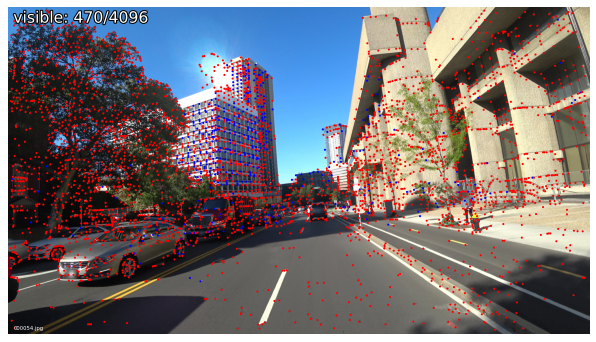

In [13]:
visualization.visualize_sfm_2d(
    model,
    images,
)

In [1]:
import pycolmap

reconstruction_dir = "/home/vamsik1211/Data/Projects/3D-Reconstructions/CityScapeGS/data/Urban3D-Dataset/ArtSci/Smith et al/ArtSci_fine/hloc_outputs/sfm"
reconstruction = pycolmap.Reconstruction(reconstruction_dir)

In [4]:
for camera_id, camera in reconstruction.cameras.items():
    print(f"  ID: {camera_id}, Model: {camera.model}, Width: {camera.width}, Height: {camera.height}, Params: {camera.params}")

  ID: 1901, Model: CameraModelId.PINHOLE, Width: 5472, Height: 3648, Params: [3700.41027674 3703.7295847  2736.         1824.        ]
  ID: 1900, Model: CameraModelId.PINHOLE, Width: 5472, Height: 3648, Params: [3697.11702142 3700.8328401  2736.         1824.        ]
  ID: 1899, Model: CameraModelId.PINHOLE, Width: 5472, Height: 3648, Params: [3715.22722312 3719.89954409 2736.         1824.        ]
  ID: 1898, Model: CameraModelId.PINHOLE, Width: 5472, Height: 3648, Params: [3721.83656687 3724.00403876 2736.         1824.        ]
  ID: 1897, Model: CameraModelId.PINHOLE, Width: 5472, Height: 3648, Params: [3720.11487812 3718.26358629 2736.         1824.        ]
  ID: 1896, Model: CameraModelId.PINHOLE, Width: 5472, Height: 3648, Params: [3714.59545463 3710.10437554 2736.         1824.        ]
  ID: 1895, Model: CameraModelId.PINHOLE, Width: 5472, Height: 3648, Params: [3714.34864707 3709.80879867 2736.         1824.        ]
  ID: 1894, Model: CameraModelId.PINHOLE, Width: 5472, 